<a href="https://colab.research.google.com/github/OscarPellicer/A-New-Coefficient-of-Correlation/blob/main/Part_2_Semi_parametric_Hybrid_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi-parametric hybrid modelling — Q10 inference exercise

**Goal:** estimate the Q10 parameter `Q10` in the respiration equation from data.

At the end of the notebook export your estimated `Q10` and send it to Kai.

---

## Problem statement (Q10 formulation)

We model ecosystem respiration as a multiplicative combination of a baseline dependence on covariates $R_b(X)$ and a temperature sensitivity factor $Q_{10}$:

$$
R_{\text{eco}}(X, T_A) \;=\; R_b(X)\ \cdot\ Q_{10}^{(T_A - T_A^{\text{ref}})/10},
$$

where $X$ are covariates (may include $T_A$), $T_A$ is air temperature, and $T_A^{\text{ref}} = 15$ (by convention here).  
Our hybrid model is:

$$
\hat y \;=\; \underbrace{\mathrm{f}_{a_\theta}(X)}_{\text{NN (learned factor)}} \cdot \underbrace{Q_{10}^{(T_A - 15)/10}}_{\text{parametric }Q_{10}\text{ factor}}
$$

We parameterize $Q10 = \exp(\alpha)$ and learn $\alpha$ so $Q_{10}>0$.


In [1]:
#@title Install & imports (run first)
!pip install -q torch torchvision matplotlib numpy

In [2]:
# Imports and setup
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
torch.manual_seed(1234)
np.random.seed(1234)


Device: cpu


In [3]:
# Easy knobs for experiments
CSV_PATH = "https://raw.githubusercontent.com/KaiHCohrs/meditwin-hybrid-modeling-tutorial/main/data/respiration.csv"   # path to csv with columns x0,x1,x2,x3,y,y_obs,scenario   # path to csv with columns x0,x1,x2,x3,y,y_obs,scenario
SCENARIO_TRAIN = "train"
SCENARIO_TEST = "test"
TARGET_COL = "y_obs"   # prefer observed noisy column if present

# Model / training knobs (participants can change these quickly)
USE_TEMP_IN_NN = False        # equifinal (True) or identifiable (False)
HIDDEN = 128
NLAYERS = 3
DROPOUT = 0.0                 # set e.g. 0.1 to enable dropout
FINAL_POSITIVE = True         # softplus final activation
INIT_Q10 = 2.5                 # initial guess for Q10 (exp(log_Q10))
LR_NET = 5e-3
LR_PARAM = 5e-4               # separate LR for log_Q10 (None to share)
WEIGHT_DECAY = 0.0            # global weight decay on optimizer
NUM_EPOCHS = 2000
BATCH_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Regularization & diagnostics
REG_PARAM_L2 = 0.0            # L2 penalty on (Q10 - Q10_prior)
Q10_PRIOR = 2.0                # prior center for Q10 L2 penalty (if used)
PRINT_EVERY = 300

# Reproducibility
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

print("DEVICE:", DEVICE)


DEVICE: cpu


Data sizes — total: 9354 train: 505 test: 505


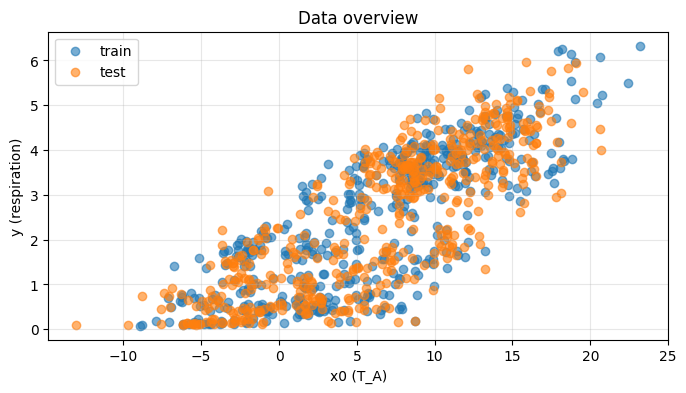

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- load CSV and basic validation ----
df = pd.read_csv(CSV_PATH)
required_cols = {"x0","x1","x2","x3","scenario"}
if not required_cols.issubset(df.columns):
    raise ValueError(f"CSV must contain columns: {required_cols}")

# pick target
target_col = TARGET_COL

# split by scenario column
scenario = df["scenario"].astype(str).values
train_mask = scenario == SCENARIO_TRAIN
test_mask  = scenario == SCENARIO_TEST

X = df[["x0","x1","x2","x3"]].values.astype(float)
y = df[target_col].values.astype(float).reshape(-1,1)

X_train = X[train_mask]; y_train = y[train_mask]
X_test  = X[test_mask];  y_test  = y[test_mask]

print("Data sizes — total:", X.shape[0], "train:", X_train.shape[0], "test:", X_test.shape[0])

# quick plot: y vs x0
plt.figure(figsize=(8,4))
plt.scatter(X_train[:,0], y_train, label="train", alpha=0.6)
plt.scatter(X_test[:,0], y_test, label="test", alpha=0.6)
plt.xlabel("x0 (T_A)"); plt.ylabel("y (respiration)")
plt.title("Data overview")
plt.legend(); plt.grid(alpha=0.3); plt.show()


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HybridModel(nn.Module):
    def __init__(self, n_inputs=4, hidden=64, nlayers=3, dropout=0.0,
                 final_positive=True, use_temp_in_nn=True, init_Q10=2.0):
        """
        - use_temp_in_nn: if True NN receives x0 as input; if False NN receives only x[:,1:].
        - dropout: probability for nn.Dropout (0 disables).
        """
        super().__init__()
        self.use_temp_in_nn = use_temp_in_nn
        nn_input = n_inputs if use_temp_in_nn else (n_inputs - 1)
        layers = []
        layers.append(nn.Linear(nn_input, hidden))
        layers.append(nn.Tanh())
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        for _ in range(nlayers-1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.Tanh())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden, 1))
        self.net = nn.Sequential(*layers)
        self.final_positive = final_positive
        # trainable log Q10
        self.log_Q10 = nn.Parameter(torch.tensor(np.log(init_Q10), dtype=torch.float32))
        # init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # x: (N,4)
        nn_in = x if self.use_temp_in_nn else x[:,1:]
        fa = self.net(nn_in)
        if self.final_positive:
            fa = F.softplus(fa) + 1e-8
        Q10 = torch.exp(self.log_Q10)   # scalar
        x0 = x[:,0:1]
        fp = Q10 ** ((x0 - 15.0) / 10.0)
        yhat = fa * fp
        return yhat, fa, Q10


In [6]:
from torch.utils.data import TensorDataset, DataLoader

def make_loaders(X_train, y_train, X_test, y_test, batch_size):
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)
    X_test_t  = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
    y_test_t  = torch.tensor(y_test, dtype=torch.float32).to(DEVICE)
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t),  batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, X_train_t, y_train_t, X_test_t, y_test_t

def train_hybrid(model, train_loader, val_loader=None, lr_net=1e-3, lr_param=None,
                 weight_decay=0.0, num_epochs=1000, reg_param_l2=0.0, Q10_prior=1.5, print_every=100):
    model = model.to(DEVICE)
    # param groups
    if hasattr(model, "log_Q10") and lr_param is not None:
        net_params = [p for n,p in model.named_parameters() if n != "log_Q10"]
        optimizer = optim.Adam([{'params': net_params, 'lr': lr_net},
                                {'params': [model.log_Q10], 'lr': lr_param}], weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr_net, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    history = {"train_loss": [], "val_loss": [], "Q10": []}

    for ep in range(1, num_epochs+1):
        model.train()
        losses = []
        for xb, yb in train_loader:
            optimizer.zero_grad()
            yhat, fa, Q10 = model(xb)
            loss = criterion(yhat, yb)
            if reg_param_l2 > 0.0:
                loss = loss + reg_param_l2 * ( (Q10 - Q10_prior)**2 )
            loss.backward()
            optimizer.step()
            losses.append(float(loss.item()))
        # epoch end: evaluation
        model.eval()
        with torch.no_grad():
            # train
            train_losses = []
            for xb, yb in train_loader:
                yhat, _, _ = model(xb)
                train_losses.append(float(((yhat - yb)**2).mean().item()))
            train_loss = float(np.mean(train_losses))
            # val
            if val_loader is not None:
                val_losses = []
                for xb, yb in val_loader:
                    yhat, _, _ = model(xb)
                    val_losses.append(float(((yhat - yb)**2).mean().item()))
                val_loss = float(np.mean(val_losses))
            else:
                val_loss = None
            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)
            history["Q10"].append(float(torch.exp(model.log_Q10).cpu().numpy()))
        if ep % print_every == 0 or ep==1 or ep==num_epochs:
            print(f"Epoch {ep:4d} | train {train_loss:.4e} | val {val_loss} | Q10 {history['Q10'][-1]:.4f}")
    return model, history


Epoch    1 | train 1.0058e+00 | val 1.05366331897676 | Q10 2.4953
Epoch  300 | train 1.4385e-01 | val 0.20112140104174614 | Q10 1.8311
Epoch  600 | train 1.9243e-01 | val 0.23619144910480827 | Q10 1.7228
Epoch  900 | train 1.5452e-01 | val 0.17580951750278473 | Q10 1.6583
Epoch 1200 | train 1.8407e-01 | val 0.20885127782821655 | Q10 1.7385
Epoch 1500 | train 1.8382e-01 | val 0.22319524898193777 | Q10 1.7238
Epoch 1800 | train 2.0503e-01 | val 0.2380076041445136 | Q10 1.7481
Epoch 2000 | train 2.4009e-01 | val 0.28509164205752313 | Q10 1.5462


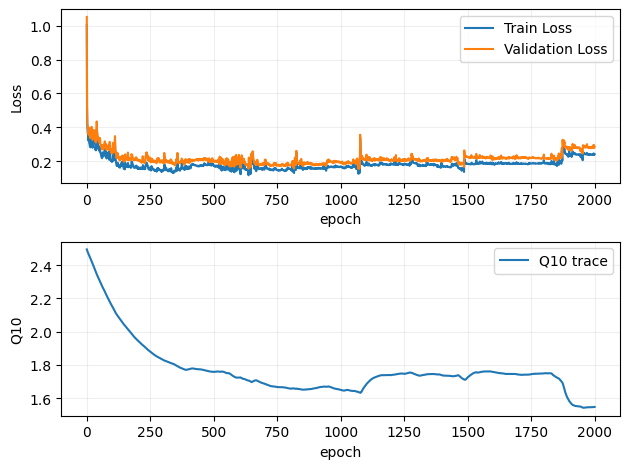

Final learned Q10: 1.5462437868118286


In [7]:
# prepare loaders
train_loader, test_loader, X_train_t, y_train_t, X_test_t, y_test_t = make_loaders(X_train, y_train, X_test, y_test, BATCH_SIZE)

#instantiate model with knobs
model = HybridModel(n_inputs=4, hidden=HIDDEN, nlayers=NLAYERS, dropout=DROPOUT,
                    final_positive=FINAL_POSITIVE, use_temp_in_nn=USE_TEMP_IN_NN, init_Q10=INIT_Q10).to(DEVICE)

# train
model, history = train_hybrid(model, train_loader, val_loader=test_loader,
                              lr_net=LR_NET, lr_param=LR_PARAM, weight_decay=WEIGHT_DECAY,
                              num_epochs=NUM_EPOCHS, reg_param_l2=REG_PARAM_L2, Q10_prior=Q10_PRIOR,
                              print_every=PRINT_EVERY)

# plotting helper
def plot_results(history, Q10_true=None):
    plt.subplot(2,1,1)
    plt.plot(history["train_loss"], label='Train Loss')
    plt.plot(history["val_loss"], label='Validation Loss')
    plt.xlabel('epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(alpha=0.2)
    plt.subplot(2,1,2)
    plt.plot(history["Q10"], label='Q10 trace')
    if Q10_true is not None:
        plt.axhline(Q10_true, color='k', linestyle='--', label='true Q10')
    plt.xlabel('epoch'); plt.ylabel('Q10'); plt.legend(); plt.grid(alpha=0.2)
    plt.tight_layout(); plt.show()

# plot
plot_results(history, Q10_true=None)

# print final Q10
final_Q10 = float(torch.exp(model.log_Q10).detach().cpu().numpy())
print("Final learned Q10:", final_Q10)


## Optional things to play with (make them easy to change at top):
- **capacity of the network**: change `HIDDEN` and `NLAYERS`.
- **learning rates**: change `LR_NET` and `LR_PARAM`.
- **with or without `T_A` (`x0`) in the NN**: set `USE_TEMP_IN_NN = True/False`.
- **regularization**: change `WEIGHT_DECAY` (optimizer weight decay).
- **dropout**: set `DROPOUT = 0.1` (or 0.2) to enable Dropout in the NN.
- **initial value**: change `INIT_Q10` (initial guess).
- **Q10 prior**: can you anchor the estimations in the equifinal case (with `T_A` in NN) through a prior on the Q10? Can the NN compensate bad estimate?

Try a few combinations and compare the final `Q10` estimates. Send your estimations and the validation performance to Kai.
